In [208]:
import torch
from torch import nn
from torch import functional as F
import re
from torch import optim
import matplotlib.pyplot as plt
import string
import random
import sys
import pandas as pd
import numpy as np

In [150]:
with open("Syllable_dictionary.txt") as f:
    syllables = [line.rstrip('\n') for line in f]
    f.close()
with open("shakespeare.txt") as f:
#     data = [line.rstrip('\n') for line in f]
    dataChar = [line for line in f]
    f.close()

In [151]:
syllableDict = {}
for n in range(len(syllables)):
    splitted = syllables[n].split()
    syllableDict[splitted[0]] = splitted[1:]
    


In [153]:
data2Lines = []
count = 0
while True:
    if count == len(data):
        break
    if len(data[count]) == 1:
        count += 1
        continue
    data2Lines.append(data[count].split()+ data[count+1].split())
    count += 2

 
        

NameError: name 'data' is not defined

(array([ 460.,    0.,    0.,    0.,    2.,   95.,  790., 1014.,  240.,
          14.]),
 array([ 1. ,  6.9, 12.8, 18.7, 24.6, 30.5, 36.4, 42.3, 48.2, 54.1, 60. ]),
 <BarContainer object of 10 artists>)

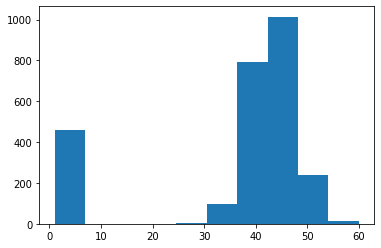

In [229]:
plt.hist([len(x) for x in dataChar])

In [209]:
with open("shakespeare.txt") as f:
#     data = [line.rstrip('\n') for line in f]
    dataChar = [line for line in f]
    f.close()

dataChar = [re.sub('^ *|[1-9]', '', x).lower() for x in dataChar]

dataCharStr = ''
for n in dataChar:
    dataCharStr += n + ' '

possibleLetters = ''
for n in pd.Series(list(dataCharStr)).unique():
    possibleLetters += n

In [210]:
def string_vectorizer(strng, alphabet=possibleLetters):
    vector = [[0 if char != letter else 1 for char in alphabet] 
                  for letter in strng]
    return vector

In [211]:
vectorized = string_vectorizer(dataCharStr)
data40grams = []
for n in range(len(vectorized)-40):
    data40grams.append(vectorized[n:n+40])



In [212]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_char = len(possibleLetters)

In [213]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, cell):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))
        out = self.fc(out.reshape(out.shape[0], -1))
        return out, (hidden, cell)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [239]:
class Generator():
    def __init__(self):
        self.chunk_len = 40
        self.epoch = 10000
        self.batch_size = 1
        self.print_every = 100
        self.hidden_size = 128
        self.num_layers = 1
        self.lr = 0.001
        
    def char_tensor(self, string):
        tensor = torch.zeros(len(string)).long()
        for c in range(len(string)):
            tensor[c] = possibleLetters.index(string[c])
        return tensor
    
    def get_random_batch(self):
        start_idx = random.randint(0, len(dataCharStr)-self.chunk_len)
        end_idx = start_idx + self.chunk_len + 1
        text_str = dataCharStr[start_idx: end_idx]
        text_input = torch.zeros(self.batch_size, self.chunk_len)
        text_target = torch.zeros(self.batch_size, self.chunk_len)
        
        for i in range(self.batch_size):
            text_input[i,:] = self.char_tensor(text_str[:-1])
            text_target[i,:] = self.char_tensor(text_str[1:])
            
        return text_input.long(), text_target.long()

    def get_seq_batch(self, index):
        start_idx = index
        end_idx = start_idx + self.chunk_len + 1
        text_str = dataCharStr[start_idx: end_idx]
        text_input = torch.zeros(self.batch_size, self.chunk_len)
        text_target = torch.zeros(self.batch_size, self.chunk_len)

        for i in range(self.batch_size):
            text_input[i,:] = self.char_tensor(text_str[:-1])
            text_target[i,:] = self.char_tensor(text_str[1:])

        return text_input.long(), text_target.long()

    
    # 560 pred length
    def generate(self, initial_str = "shall i compare thee to a summer's day?\n", predict_len = 560, temperature = 0.5):
        hidden, cell = self.rnn.init_hidden(batch_size = self.batch_size)
        initial_input = self.char_tensor(initial_str)
        predicted = initial_str
        
        for p in range(len(initial_str) - 1):
            _, (hidden, cell) = self.rnn(initial_input[p].view(1).to(device), hidden, cell)
            
        last_char = initial_input[-1]
        
        for p in range(predict_len):
            output, (hidden, cell) = self.rnn(last_char.view(1).to(device), hidden, cell)
            output_dist = output.data.view(-1).div(temperature).exp()
            top_char = torch.multinomial(output_dist, 1)[0]
            predicted_char = possibleLetters[top_char]
            predicted += predicted_char
            last_char = self.char_tensor(predicted_char)
            
        return predicted
            
            
            
    def train(self):
        self.rnn = RNN(n_char, self.hidden_size, self.num_layers, n_char).to(device)
        optimizer = optim.Adam(self.rnn.parameters(), lr = self.lr)
        criterion = nn.CrossEntropyLoss()
        print("starting Training")
        for epoch in range(self.epoch + 1):
#             if epoch > len(dataCharStr)-self.chunk_len:
#                 inp, target = self.get_random_batch()
#             else:
#                 inp, target = self.get_seq_batch(epoch)
                
            
            inp, target = self.get_random_batch()
            hidden, cell = self.rnn.init_hidden(batch_size = self.batch_size)
            
            self.rnn.zero_grad()
            loss = 0
            inp = inp.to(device)
            target = target.to(device)
            
            for c in range(self.chunk_len):
                output, (hidden, cell) = self.rnn(inp[:, c], hidden, cell)
                loss += criterion(output, target[:,c])
            
            loss.backward()
            optimizer.step()
            loss = loss.item()/self.chunk_len
            if epoch % self.print_every == 0:
                print('Epoch '+ str(epoch) + ', Loss: ' + str(loss))
                
        
        

In [240]:
gen = Generator()
gen.train()

starting Training
Epoch 0, Loss: 3.6834205627441405
Epoch 100, Loss: 2.4205188751220703
Epoch 200, Loss: 2.2011014938354494
Epoch 300, Loss: 2.207248878479004
Epoch 400, Loss: 1.6391851425170898
Epoch 500, Loss: 2.055007743835449
Epoch 600, Loss: 2.109011650085449
Epoch 700, Loss: 1.94483642578125
Epoch 800, Loss: 1.8964420318603517
Epoch 900, Loss: 1.9573982238769532
Epoch 1000, Loss: 2.192524528503418
Epoch 1100, Loss: 1.8854570388793945
Epoch 1200, Loss: 1.4781264305114745
Epoch 1300, Loss: 1.7501296997070312
Epoch 1400, Loss: 1.9073600769042969
Epoch 1500, Loss: 1.677298355102539
Epoch 1600, Loss: 1.614409828186035
Epoch 1700, Loss: 1.9906970977783203
Epoch 1800, Loss: 1.534061813354492
Epoch 1900, Loss: 1.5593320846557617
Epoch 2000, Loss: 1.932499885559082
Epoch 2100, Loss: 1.664933204650879
Epoch 2200, Loss: 1.8069414138793944
Epoch 2300, Loss: 1.8845943450927733
Epoch 2400, Loss: 1.6798721313476563
Epoch 2500, Loss: 2.263457679748535
Epoch 2600, Loss: 1.895555305480957
Epoch 27

In [241]:
gen.generate()

"shall i compare thee to a summer's day?\n that of grained me thou will of thy self thou contant with most stand grow,\n and so that me thou self my self will i ergrows and for i after in the self the say,\n and seet me for my self with for me thou pair with shadow will still stanned and heart.\n \n \n \n \n \n which was the will to that this light eyes for and he wert but see mind,\n the one the beauty with new bath that under will in i not spent,\n mine i since of that me love and thee were that heart,\n the doth pride i not still with my self is will me strom thy doth in thee with me fill stain,\n the se"